In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import RobertaTokenizer, RobertaModel
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
from collections import OrderedDict

In [50]:
class CustomModel(nn.Module):
    def __init__(self, config: dict, auto_tokenize=True):
        super(CustomModel, self).__init__()
        self.auto_tokenize = auto_tokenize
        self.tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        self.classifier = nn.Sequential(OrderedDict([
            ('dense', nn.Linear(config['dense_in'], config['dense_out'])),
            ('dropout', nn.Dropout(config['dropout'])),
            ('out', nn.Linear(config['dense_out'], config['num_labels']))
        ]))

    def forward(self, tokens, return_complete_output=False):
        if self.auto_tokenize:
            input = self.tokenizer(tokens, padding='max_length', truncation=config['truncation'], max_length=config['max_length'], return_tensors='pt')
        else:
            input = tokens

        x = self.roberta(**input)
        x = self.classifier(x[0][:, 0]) # from last hidden state, for CLS token
        # source for CLS embeddings: https://www.kaggle.com/code/rhtsingh/utilizing-transformer-representations-efficiently
        
        output = {
            'domain': F.softmax(x[:, :3], dim=1),
            'html_dir': F.softmax(x[:, 11:], dim=1),
        }

        html_lang = F.sigmoid(x[:, 3:7])
        content_language = F.sigmoid(x[:, 7:11])
        
        output['html_lang'] = html_lang
        output['content_language'] = content_language
        
        return output

In [33]:
config = {
    'num_labels': 14,
    'dense_in': 768,
    'dense_out': 768,
    'dropout': 0.1,
    'truncation': True,
    'max_length': 128
}

In [34]:
domains = ['es', 'us', 'ru']
domains_dict = { cls:i for i, cls in enumerate(domains) }

dirs = ['ltr', 'rtl', '']
dirs_dict = { cls:i for i, cls in enumerate(dirs) }

html_langs = ['es', 'en', 'ru', 'cn']
html_langs_dict = { cls:i for i, cls in enumerate(html_langs) }

content_langs = ['es', 'en', 'ru', 'cn']
content_langs_dir = { cls:i for i, cls in enumerate(content_langs) }

def one_hot_domain(str_cls):
    cls = domains_dict[str_cls]
    return torch.nn.functional.one_hot(torch.tensor(cls), num_classes=3).float().unsqueeze(0)

def one_hot_dir(str_cls):
    cls = dirs_dict[str_cls]
    return torch.nn.functional.one_hot(torch.tensor(cls), num_classes=3).float().unsqueeze(0)

def one_hot_html_lang(str_cls):
    cls = html_langs_dict[str_cls]
    return torch.nn.functional.one_hot(torch.tensor(cls), num_classes=4).float().unsqueeze(0)

def encode_html_lang(*args):
    indices = []
    for arg in args:
        indices.append(html_langs_dict[arg])

    tensor = torch.zeros(4)
    for idx in indices:
        tensor[idx] = 1

    return tensor.unsqueeze(0)

def one_hot_content_lang(str_cls):
    cls = content_langs_dir[str_cls]
    return torch.nn.functional.one_hot(torch.tensor(cls), num_classes=4).float().unsqueeze(0)

def encode_content_lang(*args):
    indices = []
    for arg in args:
        indices.append(html_langs_dict[arg])

    tensor = torch.zeros(4)
    for idx in indices:
        tensor[idx] = 1

    return tensor.unsqueeze(0)

In [35]:
sample_dataset = [
    # (text, domain, html_lang, content_language, html_dir)
    ('texto de prueba', one_hot_domain('es'), encode_html_lang('es', 'ru'), encode_content_lang('es', 'ru'), one_hot_dir('ltr')),
    ('otro texto', one_hot_domain('es'), encode_html_lang('es', 'ru'), encode_content_lang('es', 'ru'), one_hot_dir('ltr')),
    ('this is english', one_hot_domain('us'), encode_html_lang('en') , encode_content_lang('en'), one_hot_dir('ltr')),
    ('this is also another text', one_hot_domain('us'), encode_html_lang('en'), encode_content_lang('en'), one_hot_dir('ltr'))
]

In [36]:
cross_entropy_loss = nn.CrossEntropyLoss()
binary_cross_entropy_loss = nn.BCELoss()

custom_model = CustomModel(config)
custom_model.train()

lr = 1e-5
optimizer = torch.optim.AdamW(custom_model.parameters(), lr=lr)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10	loss: 0.8887870460748672
Epoch 2/10	loss: 0.8740910887718201
Epoch 3/10	loss: 0.871831551194191
Epoch 4/10	loss: 0.8432279229164124
Epoch 5/10	loss: 0.8239980340003967
Epoch 6/10	loss: 0.7732236832380295
Epoch 7/10	loss: 0.7152294814586639
Epoch 8/10	loss: 0.6834849119186401
Epoch 9/10	loss: 0.6495937556028366
Epoch 10/10	loss: 0.624142661690712


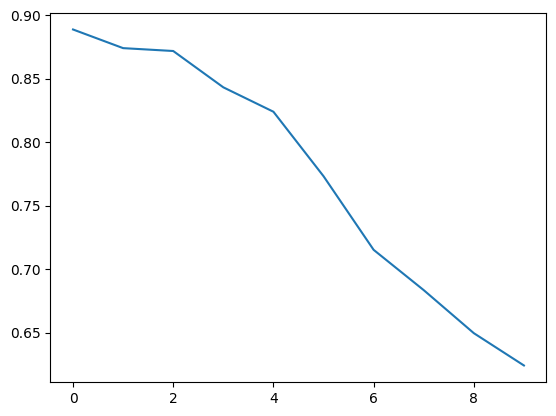

In [37]:
custom_model.train()

training_loss = []

epochs = 10

for epoch in range(epochs):
    losses = []
    for text, domain, html_lang, content_language, html_dir in sample_dataset:
        predicted = custom_model(text)
        predicted_domain = predicted['domain']
        predicted_html_lang = predicted['html_lang']
        predicted_content_language = predicted['content_language']
        predicted_html_dir = predicted['html_dir']
        
        domain_loss = cross_entropy_loss(predicted_domain, domain)
        html_lang_loss = binary_cross_entropy_loss(predicted_html_lang, html_lang)
        content_language_loss = binary_cross_entropy_loss(predicted_content_language, content_language)
        html_dir_loss = cross_entropy_loss(predicted_html_dir, html_dir)
        
        total_loss = domain_loss + html_lang_loss + content_language_loss + html_dir_loss
        total_loss /= 4.0

        losses.append(total_loss.item())
    
        optimizer.zero_grad(set_to_none=True)
        total_loss.backward()
        optimizer.step()
        
    average_loss = sum(losses)/len(losses)
    training_loss.append(average_loss)

    print(f'Epoch {epoch+1}/{epochs}\tloss: {average_loss}')

plt.plot(training_loss);

In [38]:
custom_model.eval();

In [44]:
output = custom_model('texto de prueba')

In [45]:
output['domain']

tensor([[0.7222, 0.1931, 0.0847]], grad_fn=<SoftmaxBackward0>)

In [46]:
output['html_dir']

tensor([[0.9360, 0.0366, 0.0275]], grad_fn=<SoftmaxBackward0>)

In [47]:
output['content_language']

tensor([[0.6107, 0.3178, 0.6306, 0.1874]], grad_fn=<SigmoidBackward0>)

In [48]:
output['html_lang']

tensor([[0.5766, 0.3618, 0.6352, 0.1815]], grad_fn=<SigmoidBackward0>)